In [15]:
""" Prova """

import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

import math
import matplotlib
from matplotlib import ticker
import os,sys
import matplotlib.pylab as plt

from pylab import polyfit

from IPython.display import Markdown # for color printing 

# define a function for pretty plotting 
def cprint(text, color):
    """ Nicely color-prints the text given with the color chosen """
    # see reference: https://htmlcolorcodes.com/
    dic ={ 'red'     : '#ff0000' , 'blue' : '#0000FF' , 'green':'#00FF00' ,
           'aqua'    : '#00FFFF' ,
           'fuchsia' : '#FF00FF' } # mapping nasmes to HTML color codes
    
    display (Markdown('<span style="color:' + dic[color] + '"> ' + text + '</span>'))


# variables of interest 
varis = ['lat', 'lon', 'plev', 'sonde_type', 'wind_speed', 'wind_speed_bias', 'wind_speed_dep',
       'wind_speed_glob', 'wind_speed_num_obs', 'wind_speed_num_obs_bias', 'wind_speed_num_obs_dep',
       'wind_speed_num_obs_glob', 'wind_speed_std_dev', 'wind_speed_std_dev_bias', 'wind_speed_std_dev_dep',
       'wind_speed_std_dev_glob', 'time', 'year', 'month', 'hour']


to_drop = ['sonde_type']

out_dir = 'Plots'
os.system('mkdir ' + out_dir )
out_dir = 'Plots/Monthly_Averages'
os.system('mkdir ' + out_dir )


month_dic = { 1 : 'January' , 2  : 'February'  , 3  : 'March'     , 4 : 'April' , 5: 'May' , 6:'June' ,
                  7 : 'July'    , 8  : 'August'    , 9  : 'September' , 
                 10 : 'October' , 11 : 'November'  , 12 : 'December'  }
    
std_plevels = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  # This is added back by InteractiveShellApp.init_path()


In [16]:
""" Load the averaged file """
variable = 'dew_point_temperature'


dir = '/raid60/scratch/federico/MONTHLY_FEB2021/' + variable + '/'
#f1 = '0-20000-0-10393_monthly_averages_' + variable + '.nc'
#station = '10393'

f1 = '0-20000-0-10393_monthly_averages_' + variable + '.nc'
station = 'Lindenberg'

average   = xr.open_dataset(dir + f1 , engine = 'h5netcdf' , decode_times = True , drop_variables= to_drop).to_dataframe()
average['year']  = pd.arrays.DatetimeArray (average['time'].values[:] ).year
average['month'] = pd.arrays.DatetimeArray (average['time'].values[:] ).month
average['hour']  = pd.arrays.DatetimeArray (average['time'].values[:] ).hour

#print(average[500:550])

In [17]:
def plot_series(average_df = '' , min_year = 1970, max_year = 2000 , pressure = '' , variable = '', months = ['1'] , station = '' , text = '', plot_errors = False):
    
    """ Plot the time series of the averages comprised between min_year and max_year. 
        average_df: dataframe of the observations_table """

    #print(average_df.columns) 
    
    months = range(1,13) 
    
    years = range(min_year, max_year)
    
    fs   = 15 # fotnsize for plotting
    
    obs_00 , obs_12, dt_12, dt_00 = [], [] , [] , []
    obs_00_global , obs_12_global = [] , []
    obs_00_reanalysis, obs_12_reanalysis = [] , []
    obs_00_unbiased, obs_12_unbiased = [] , []

    dt_12_reana, dt_00_reana = [] , [] 
    
    p = pressure
    for y in years:
                #print(y)
        for m in months:
                    #print(m)
            if m < 10:
                M = '0' + str(m) # correcting the month by adding a 0 
            else:
                M= str(m)
                        
            ts = str(y) + '-' + M + '-01'
            TS = np.datetime64(ts)
                    
            red    = average_df.loc [ ( average_df['year'] == y ) &    
                                          ( average_df['month'] == m ) & 
                                          ( average_df['plev'] == p ) ]
                    
            red_12 = red.loc [ ( red['hour'] == 12 ) ]  
            red_00 = red.loc [ ( red['hour'] == 0 ) ]  

            try:
                        obs_12.append(red_12[variable][0])
                        dt_12.append(TS)
                        
                        obs_12_global    .append(red_12[variable + '_glob'][0] )
                        obs_12_reanalysis.append(red_12[variable + '_dep'][0] )
                        obs_12_unbiased.append(red_12[variable + '_bias'][0] )


            except:
                        #print('Failed ***')
                        pass
 
            try:
                        obs_00.append(red_00[variable][0])
                        dt_00.append(TS)
                    
                        obs_00_global    .append(red_00[variable + '_glob'][0] )
                        obs_00_reanalysis.append(red_00[variale + '_dep'][0] )
                        obs_00_unbiased.append(red_00[variable + '_bias'][0] )
                        
            except:
                        #print('Failed ***')
                        pass
                    

    def plot(dt_hh, value_hh , value_hh_global, value_hh_reanalysis , value_hh_unbiased, hour = 12):

        
        fig, ax = plt.subplots(figsize=(8,7) )
        # incorrect averages 
        #plt.plot    (dt_12, value_00 , label = 'h:00 ' , color = 'lime')
        #plt.scatter (dt_00, value_00 , color = 'limegreen')

        plt.plot    (dt_hh, value_hh            , label = 'Monthly Average '    , color = 'blue' )
        plt.scatter (dt_hh, value_hh_global     , label = 'Global Average '     , color = 'red'  , s = 50 )
        #print(dt_hh, value_hh_reanalysis)
        try:
            print(len(dt_hh) , ' ' , len(value_hh_reanalysis))
            plt.scatter (dt_hh, value_hh_reanalysis , label = 'Reanalysis Average ' , color = 'black', s = 30 )
        except:
            pass
        
        #plt.scatter (dt_hh, value_hh_unbiased   , label = 'Unbiased Average '   , color = 'gold' , s = 20 )
        plt.grid(ls =":" , color = "lightgray")   

        """ General Properties """
        
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.tick_params(axis='x'   , which='major', labelsize=15 , rotation = 45)

        
        ax.tick_params(axis='both', which='minor', labelsize=8)
        #w = ax.invert_yaxis() 
        
        ax.set_ylabel( 'Time Stamp'      , fontsize = fs )     
        ax.set_ylabel( 'Dew Point [K]' , fontsize = fs )
        try:
            ax.set_ylim(min(value_hh_global)-20, max(value_hh_global)+20)
        except:
            pass
        ax.legend(loc = 'lower right', fontsize = fs-5 , ncol = 2) 
                
        plt.title("Average Dew Point h:" + hour + " - Plev=" + str(p) + ' [K] - Station ' + station , fontsize = fs , y = 1.02 )
        plt.savefig(out_dir + '/' + station + '_' + str(p) + '_' + str(hour) + '_dew_point_averages.png' ,   bbox_inches = 'tight' , dpi = 200 )

        plt.show()    
        plt.close()        
        

        
    ff = plot(dt_12, obs_12, obs_12_global, obs_12_reanalysis, obs_12_unbiased, hour = '12' )
    ff = plot(dt_00, obs_00, obs_00_global, obs_00_reanalysis, obs_00_unbiased, hour = '00' )

    # dates = date range 
    

120   120


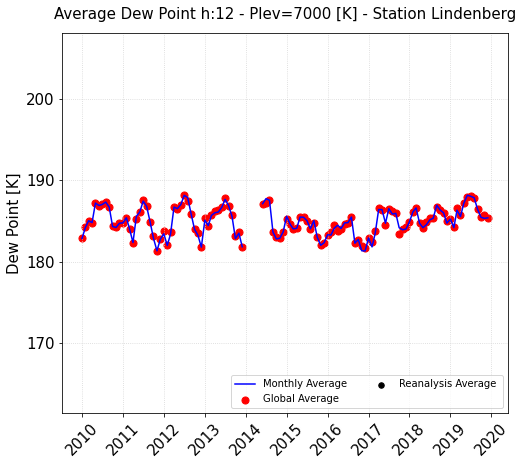

120   0


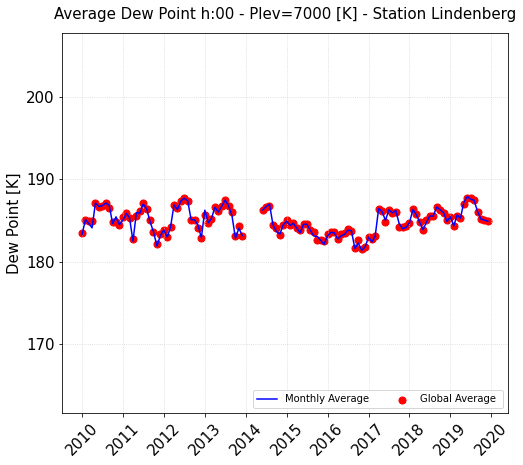

120   120


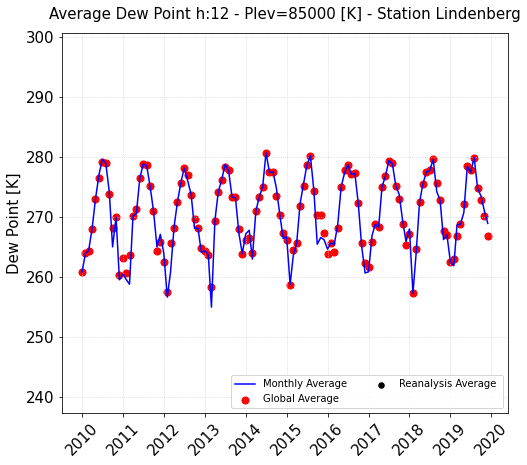

120   0


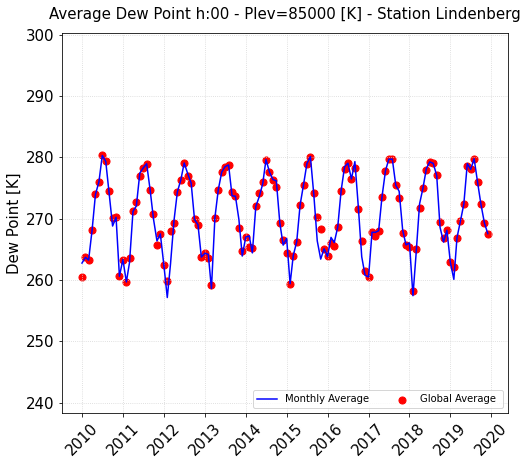

120   120


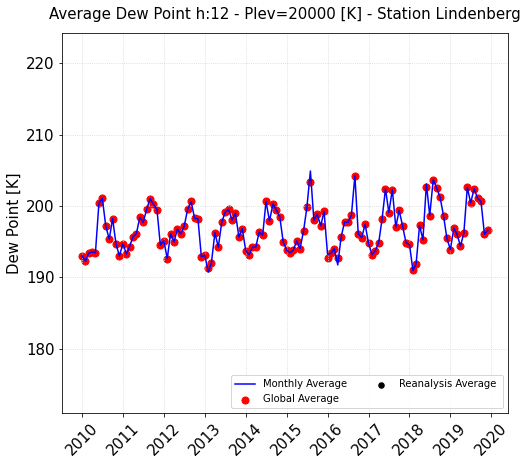

120   0


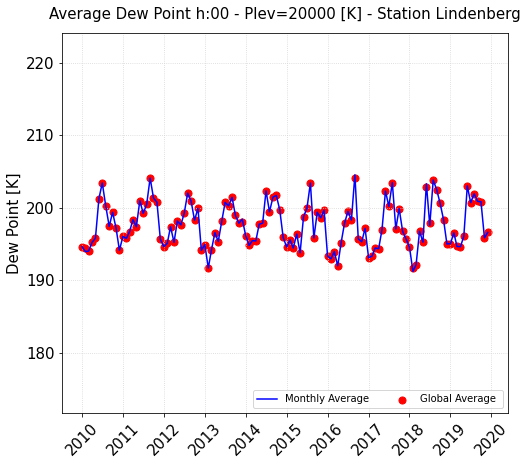

120   120


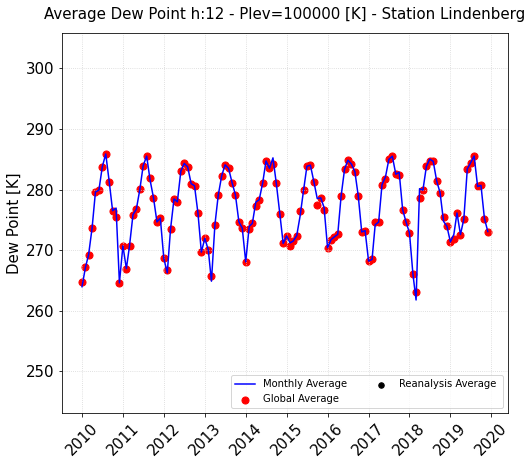

120   0


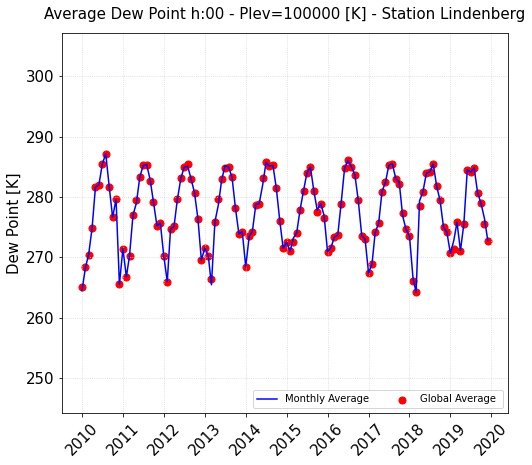

In [18]:
for p in [7000, 85000, 20000, 100000 ]:
    pp = plot_series(average_df = average, min_year = 2010, max_year = 2020 , pressure = p , station = station, plot_errors = False , variable = variable )

In [19]:
"""
Index(['date_time', 'observation_value', 'observation_value_global',
       'observation_value_reanalysis', 'observed_variable',
       'original_precision', 'original_precision_global',
       'original_precision_reanalysis', 'secondary_value',
       'secondary_value_global', 'secondary_value_reanalysis', 'sensor_id',
       'value_significance', 'z_coordinate', 'z_coordinate_type'],
      dtype='object')"""

"\nIndex(['date_time', 'observation_value', 'observation_value_global',\n       'observation_value_reanalysis', 'observed_variable',\n       'original_precision', 'original_precision_global',\n       'original_precision_reanalysis', 'secondary_value',\n       'secondary_value_global', 'secondary_value_reanalysis', 'sensor_id',\n       'value_significance', 'z_coordinate', 'z_coordinate_type'],\n      dtype='object')"

## MEANING OF THE VARIABLE
### **Monthly Average** = outliers were taken out considering only each month data
### **Global Average** = outliers were taken out considering all available data, per each month 
### **Reanalysis Average** = outliers were taken out considering reanalysis data (if reana was outlier, data point was removed) 
---

In [10]:
out_dir = 'Plots/Monthly_Averages/Profiles'
os.system('mkdir ' + out_dir )

def profile_per_month_and_year(average_df = average , min_year = 1970, max_year = 1990, station = station , text = '', variable = ''):
    """ This function plots the profile of the sonde for each available month and year in the date years range specified, for the available stadard p levels"""
    
    months = range(1,12+1) 
    years = range(min_year, max_year+1)
    
    fs = 15
    obs_00 , obs_12, dt_12, dt_00 = [], [] , [] , []
    
    '''
    month_dic = { 1 : 'January' , 2  : 'February'  , 3  : 'March'     , 4 : 'April' , 5: 'May' , 6:'June' ,
                  7 : 'July'    , 8  : 'August'    , 9  : 'September' , 
                 10 : 'October' , 11 : 'November'  , 12 : 'December'  }
    '''
    
    """ Fill the res dictionary with the temp-pressure profiles for each month and year """
    res = {}
    for y in years:
        res[y] = {}
        for m in months:
            res[y][m] = {}
            for h in [0,12]:
                res[y][m][h] = {}
                res[y][m][h]['plev'] = []
                res[y][m][h]['values']   = []

                for p in std_plevels:

                        red    = average_df.loc [ ( average_df['year'] == y ) &    
                                                  ( average_df['month'] == m ) & 
                                                  ( average_df['hour'] == h ) & 
                                                  ( average_df['plev'] == p ) ]
                                            
                        try:
                            value = red[variable + '_glob'][0]
                            res[y][m][h]['plev'].append(p)
                            res[y][m][h]['values']  .append(value)


                        except:
                            pass
 

    for m in months:
        
        found = False
        for h in [0,12]:
            fig, ax = plt.subplots(figsize=(8,7) )
            for y in years:
                #for h in [0,12]:
                    value = res[y][m][h]['values']

                    
                    press = res[y][m][h]['plev']
                
                    if len( [ v for v in value if not np.isnan(v) ] ) >1:
                        Values, Press = [],[]
                        for v,p in zip(value, press):
                            if not np.isnan(v):
                                Values.append(v)
                                Press.append(p/100)
                        
                        
                        found = True
                        plt.plot    (Values, Press , label = str(y) )
                        plt.scatter (Values, Press  )


                    else:
                        continue
            if found:
                """ Plot properties """
                #fig, ax = plt.subplots(figsize=(8,7) )

                ax.tick_params(axis='both', which='major', labelsize=15)
                ax.tick_params(axis='both', which='minor', labelsize=8)
                w = ax.invert_yaxis() 
                ax.set_ylabel( 'Pressure [hPa]'  , fontsize = fs )     
                ax.set_xlabel( 'Dew Point [K]' , fontsize = fs )        
                plt.grid(ls =":" , color = "lightgray")   
                ax.legend(loc = 'upper right', fontsize = fs-2 , ncol = 2) 
            
                plt.title("Average Dew Point h:" + str(h).replace('0','00') + " - " + month_dic[m] , fontsize = fs , y = 1.02 )
            
                plt.savefig(out_dir + '/' + station + '_dew_point_profile_averages_month_' + str(m) + '_' + text + '.png' ,   bbox_inches = 'tight' , dpi = 200 )
                plt.show()    

                plt.close()    
                
        

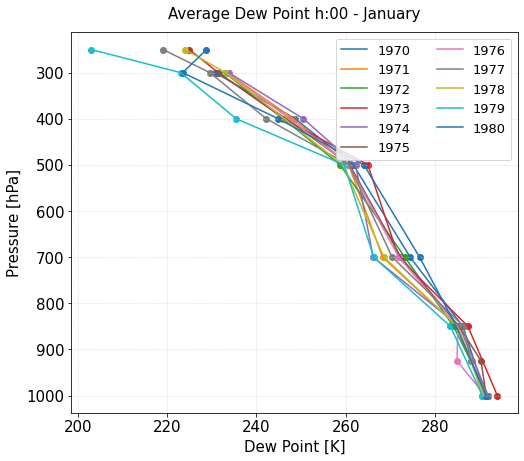

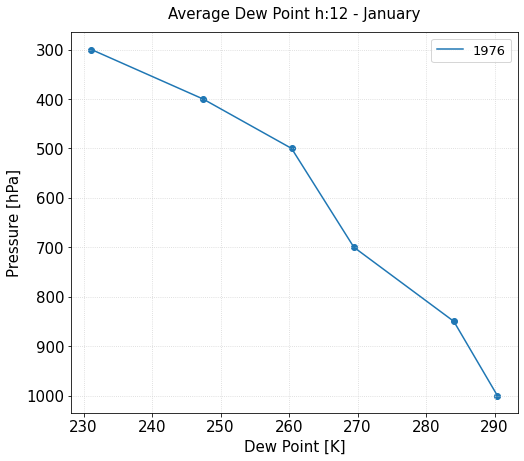

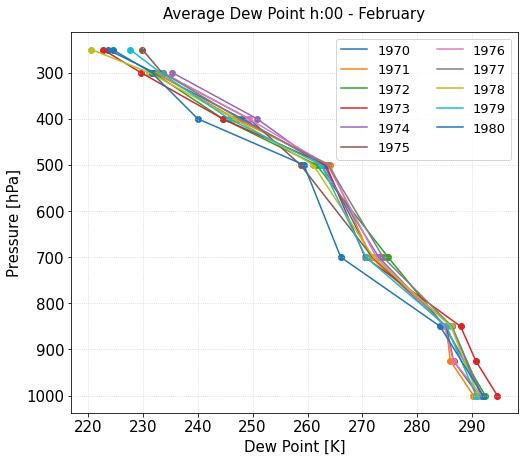

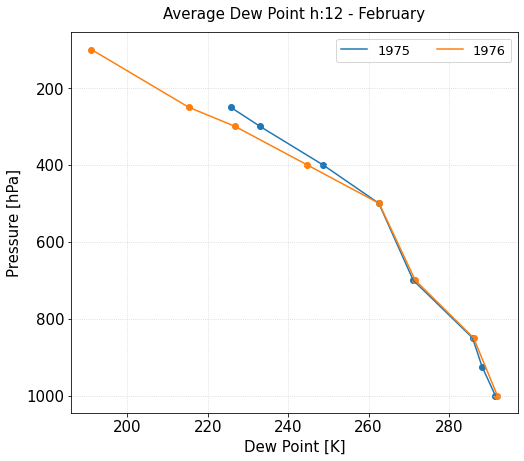

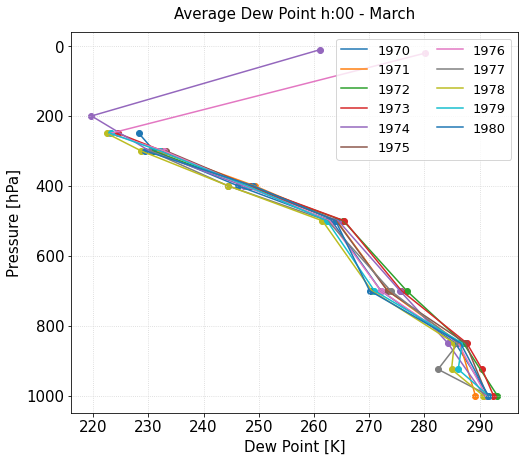

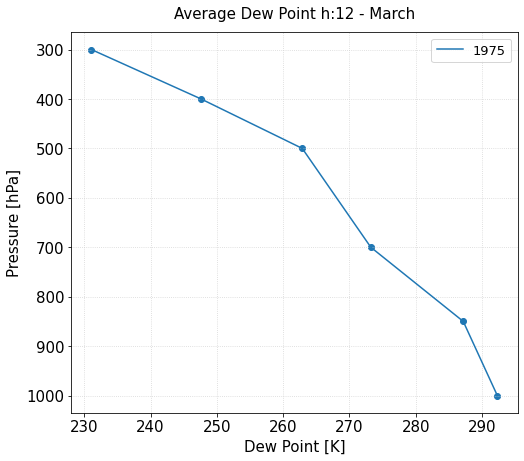

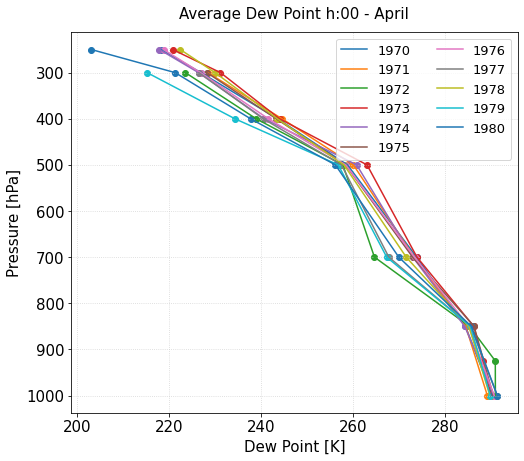

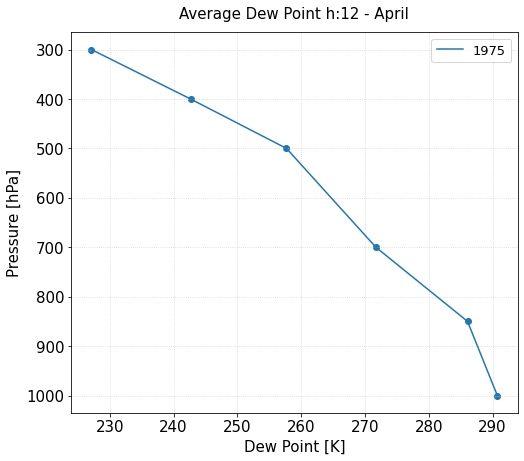

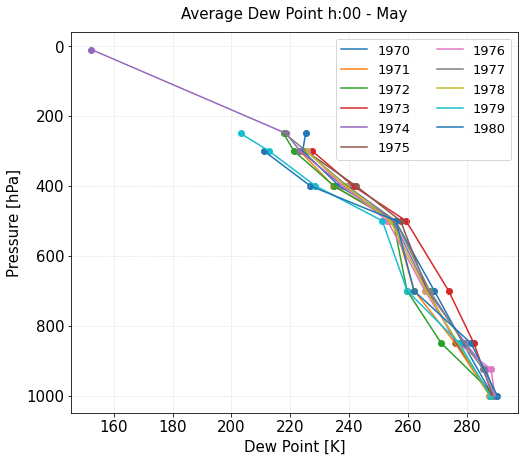

No handles with labels found to put in legend.


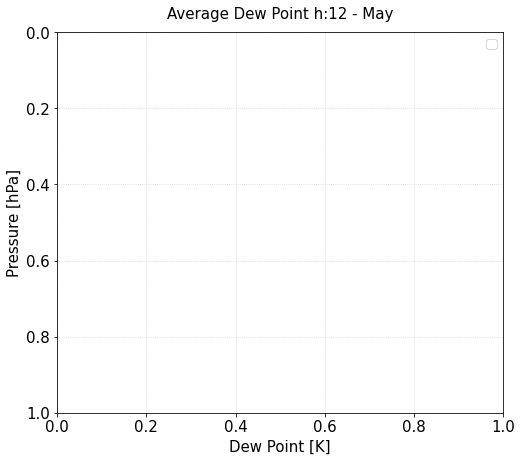

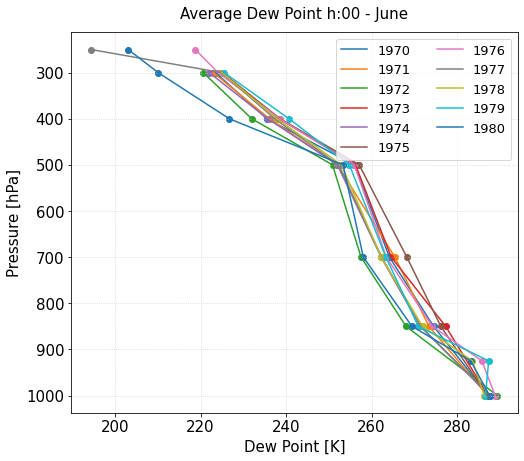

No handles with labels found to put in legend.


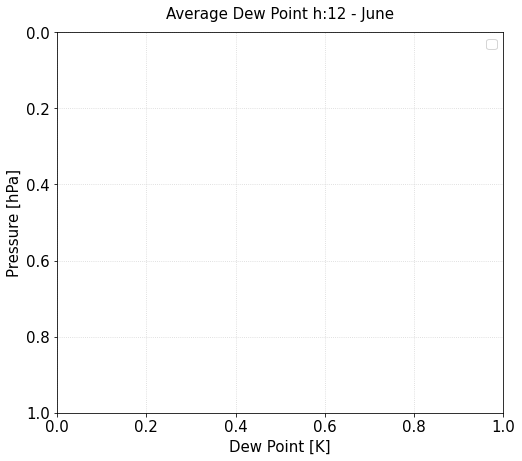

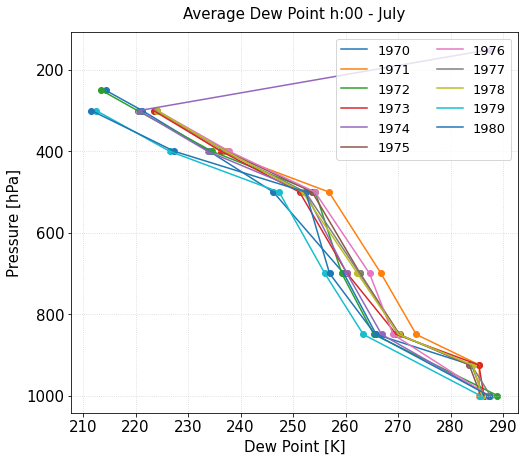

No handles with labels found to put in legend.


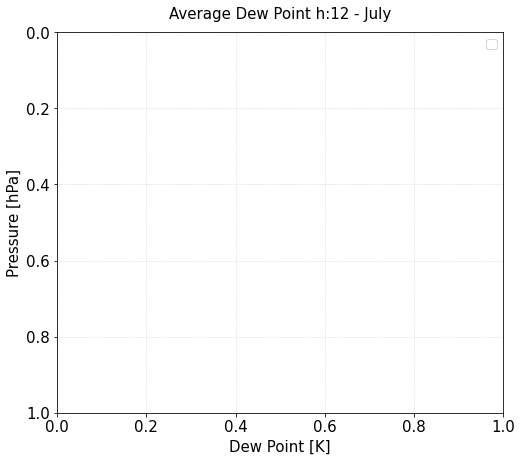

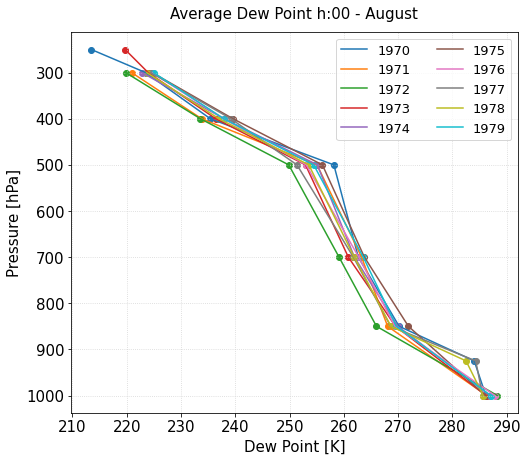

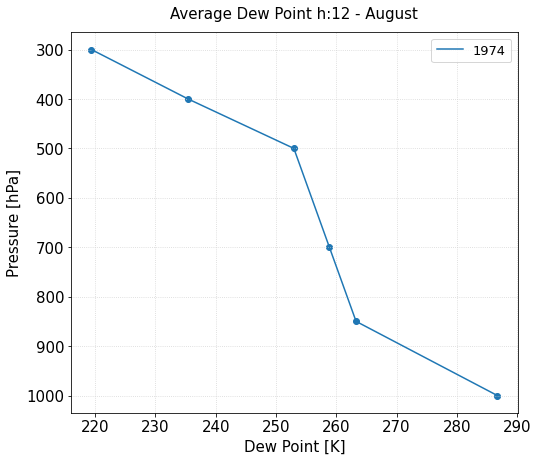

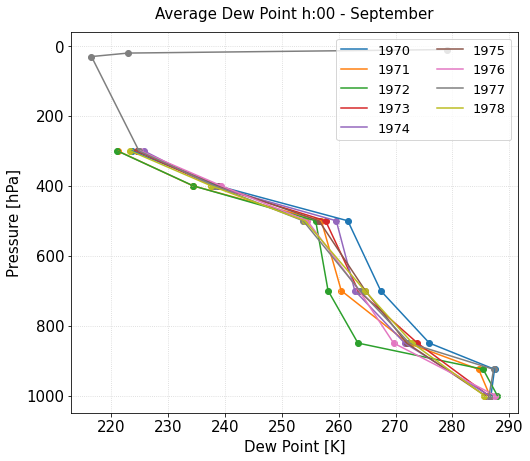

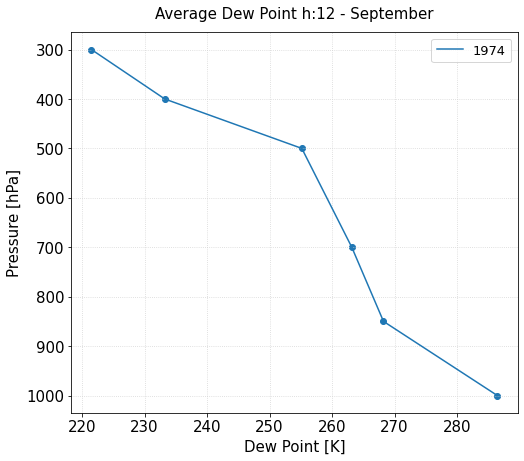

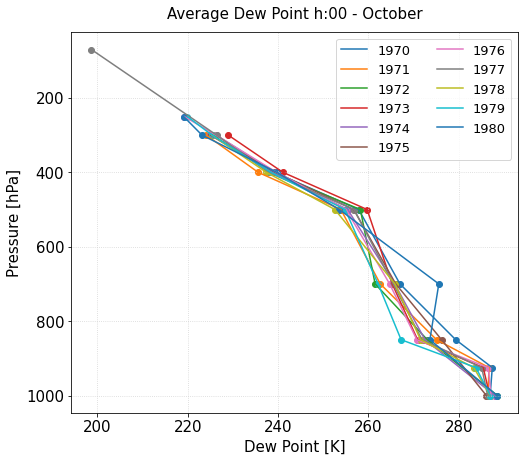

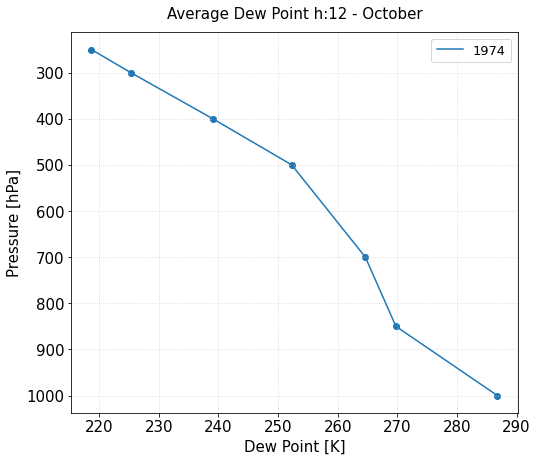

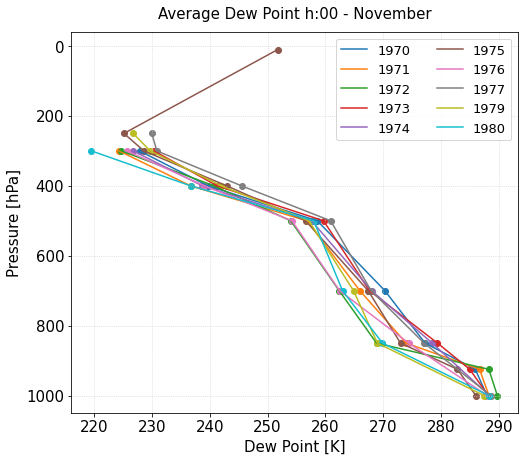

No handles with labels found to put in legend.


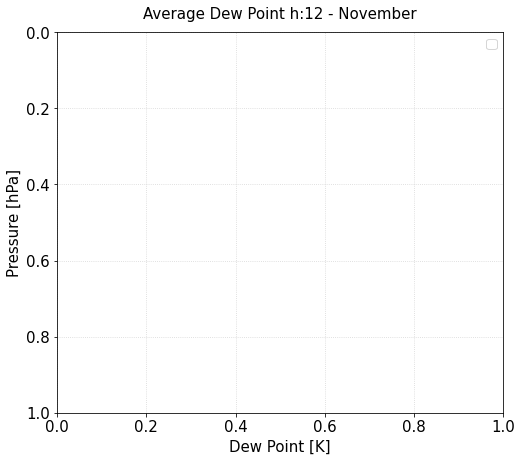

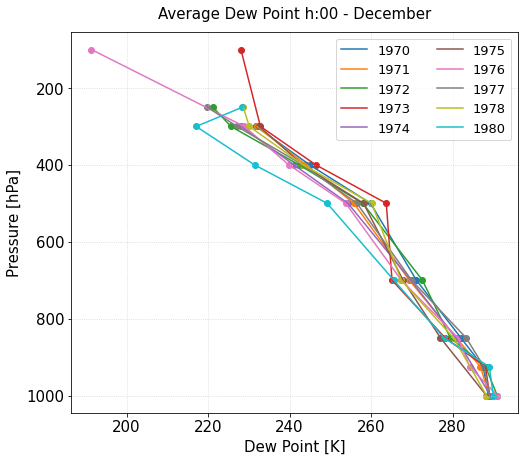

No handles with labels found to put in legend.


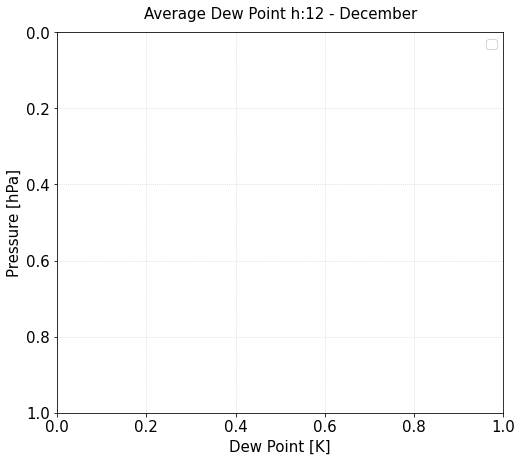

In [11]:
a = profile_per_month_and_year(average_df = average , min_year = 1970, max_year = 1980 , station = station , text='_1970-1980', variable = variable)


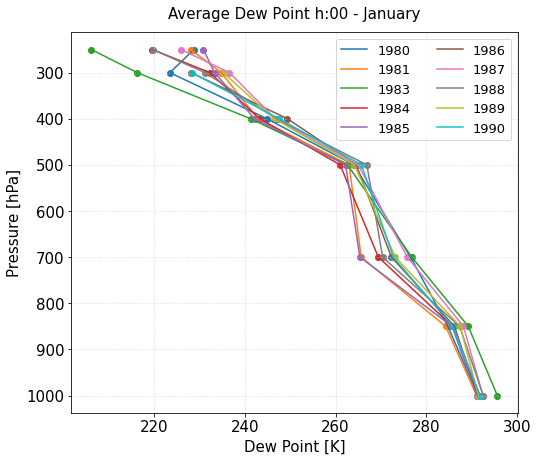

No handles with labels found to put in legend.


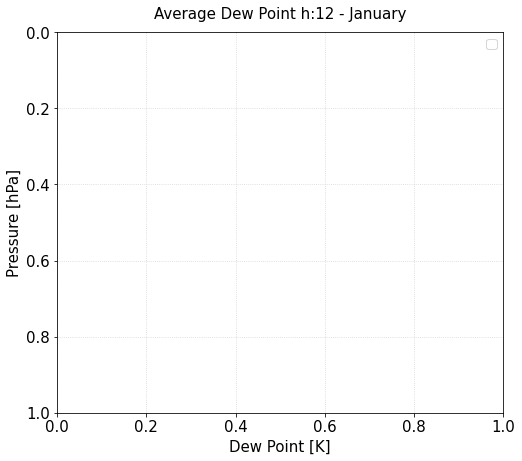

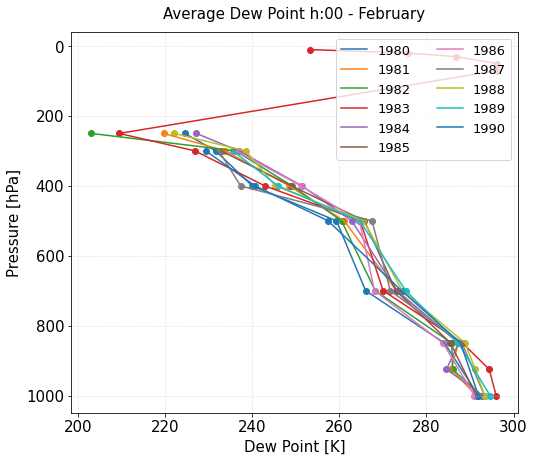

No handles with labels found to put in legend.


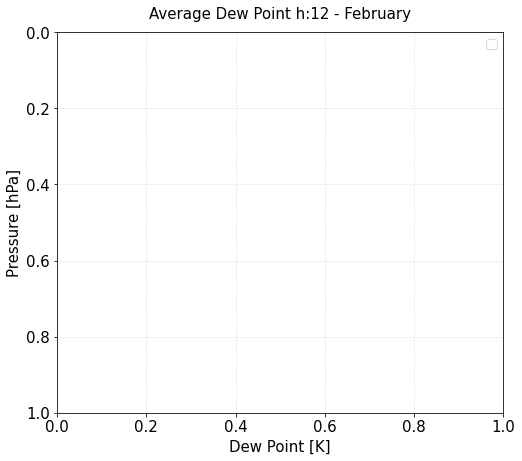

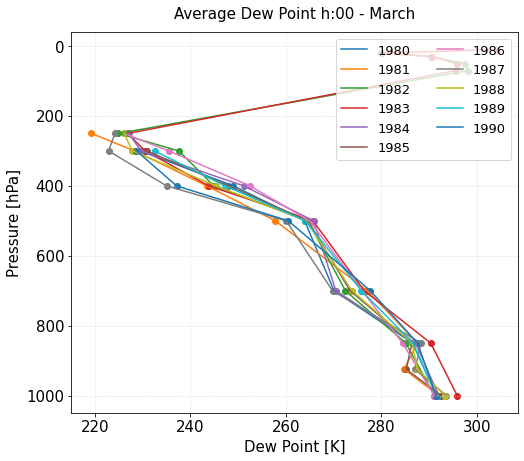

No handles with labels found to put in legend.


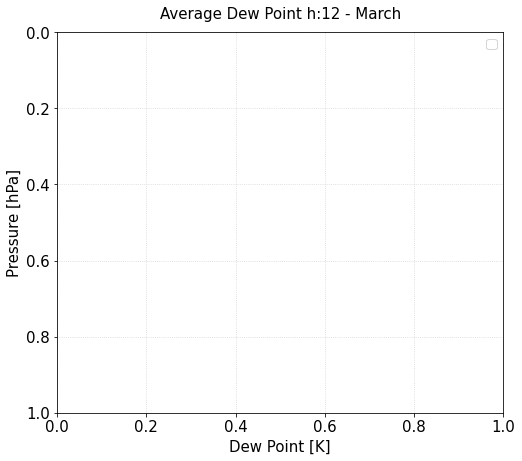

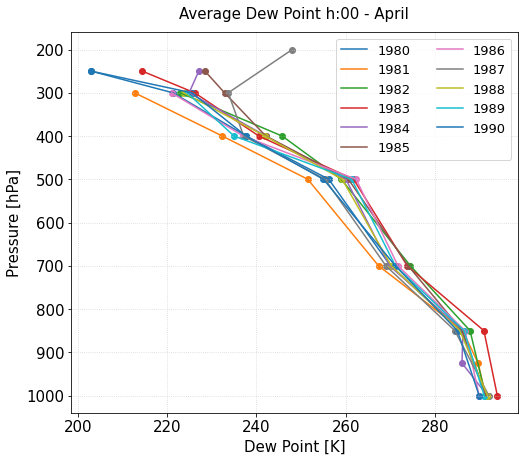

No handles with labels found to put in legend.


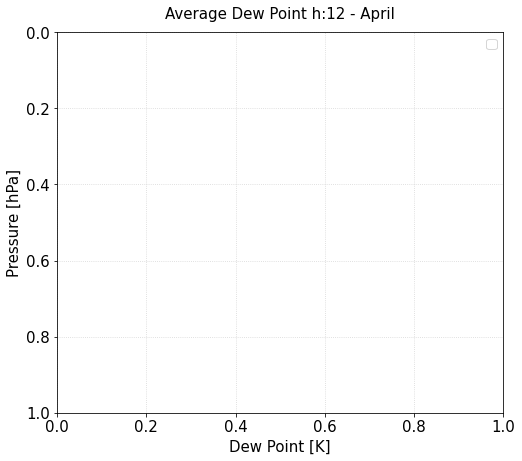

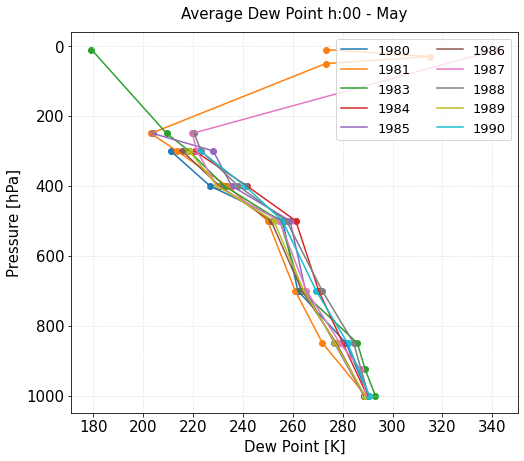

No handles with labels found to put in legend.


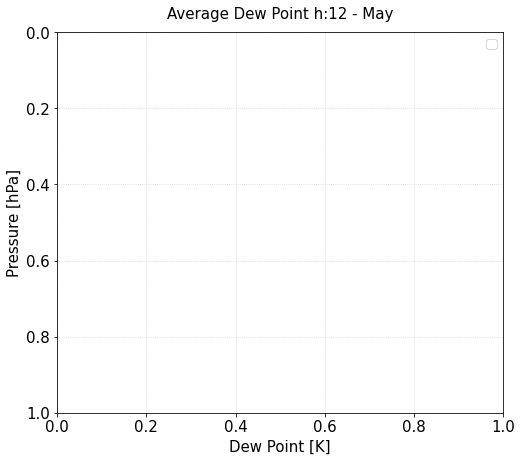

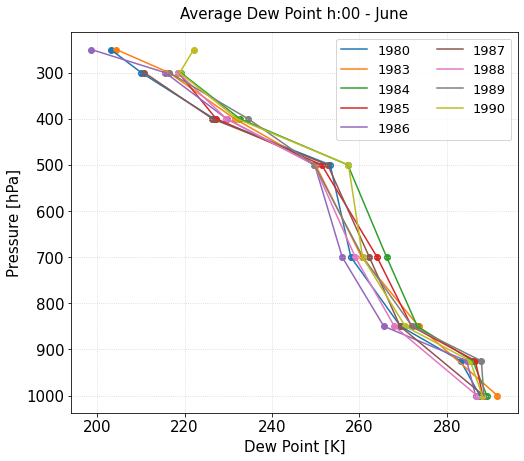

No handles with labels found to put in legend.


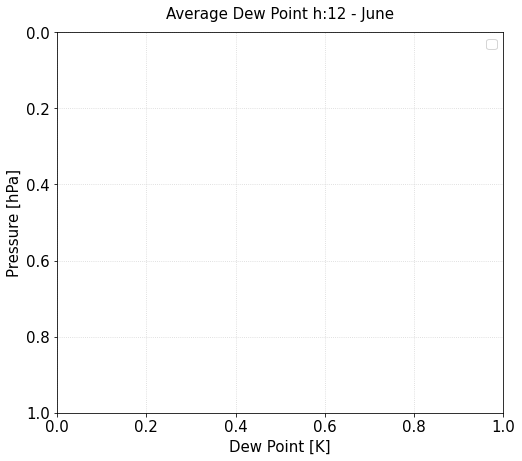

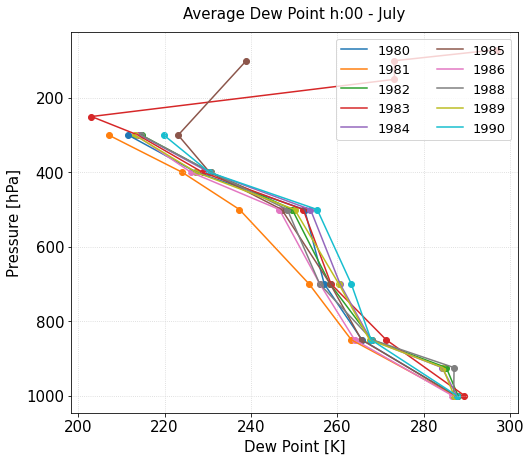

No handles with labels found to put in legend.


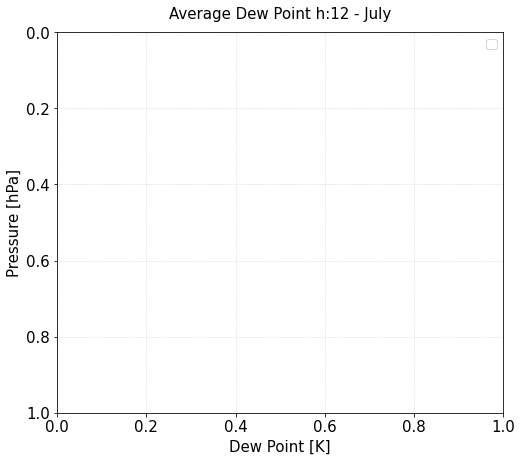

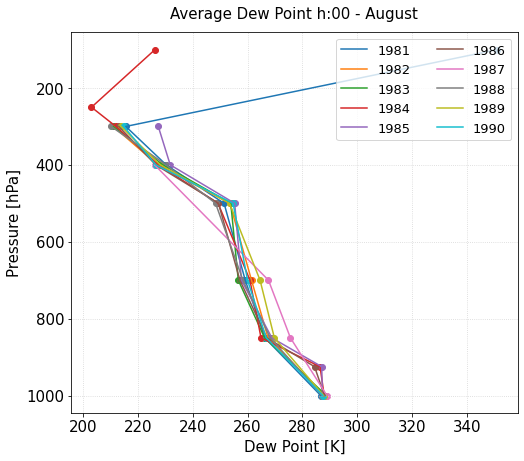

No handles with labels found to put in legend.


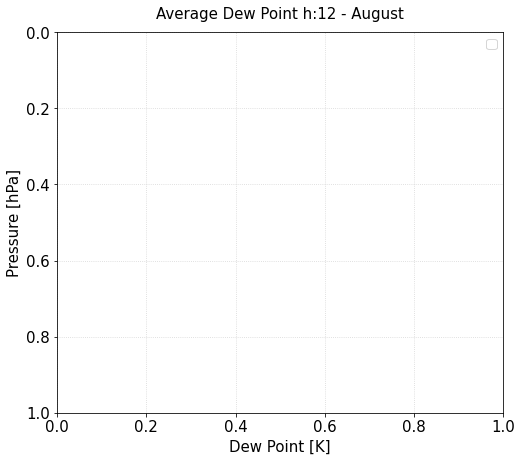

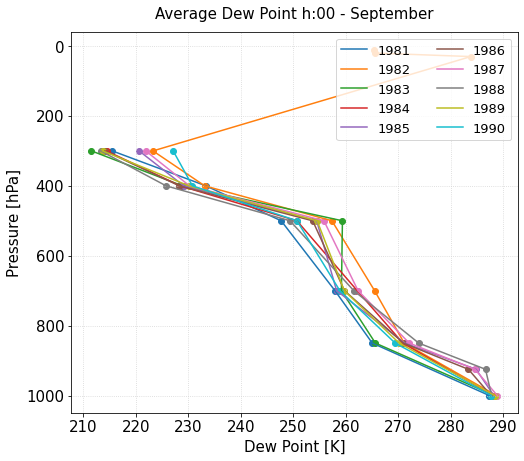

No handles with labels found to put in legend.


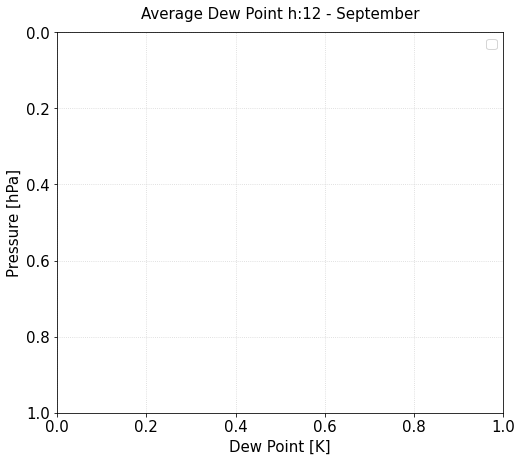

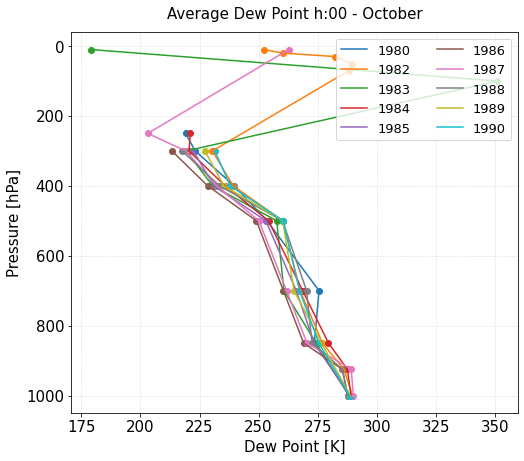

No handles with labels found to put in legend.


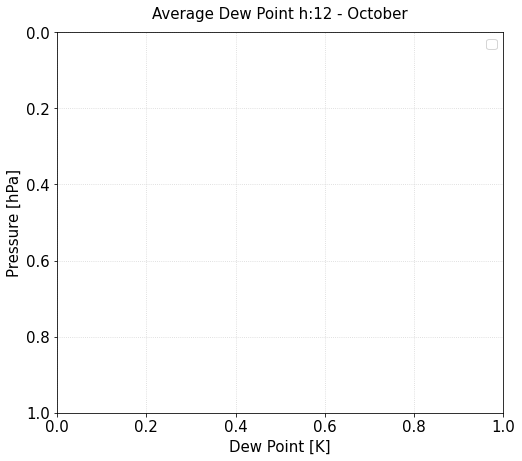

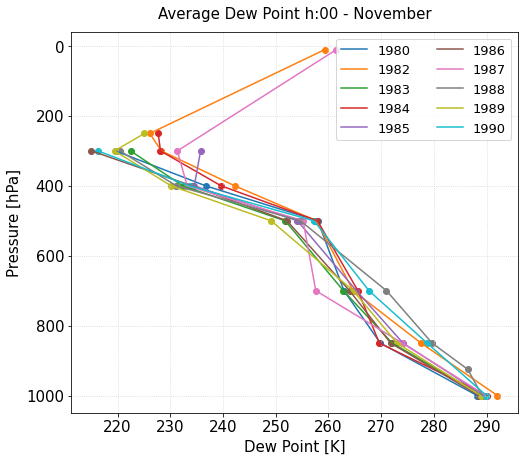

No handles with labels found to put in legend.


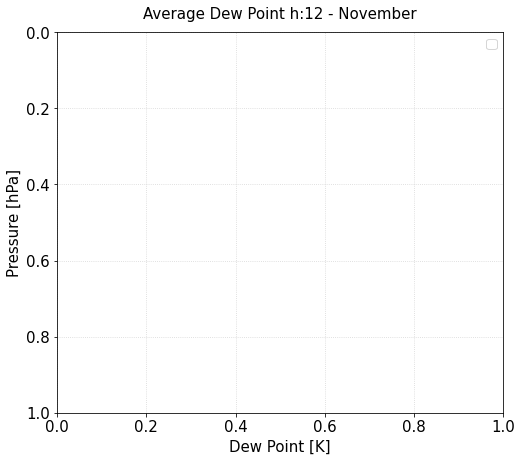

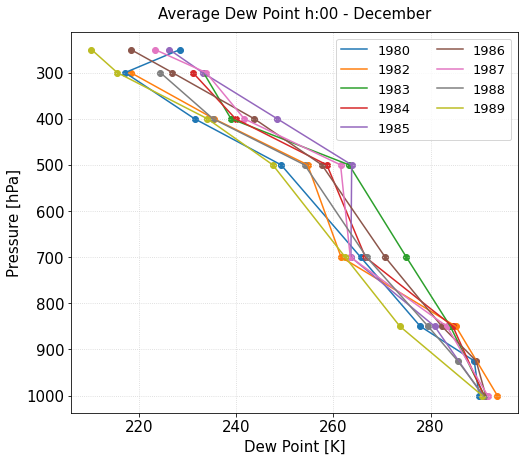

No handles with labels found to put in legend.


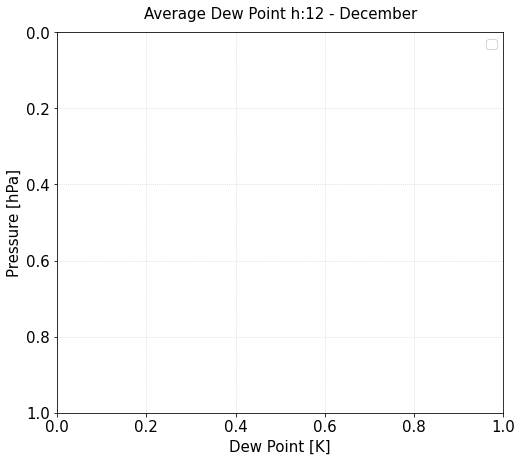

In [12]:
a = profile_per_month_and_year(average_df = average , min_year = 1980, max_year = 1990 , variable = variable , station = station , text='_1980-1990' )


In [20]:
out_dir = 'Plots/Monthly_Averages/Monthly_Series'
os.system('mkdir ' + out_dir )

def plot_climate_change(average_df = '' , min_year = 1970, max_year = 2000 , pressure = '' , month = 1 , station = '' , text = '', variable= ''):
    
    """ Plot the time series of the averages comprised between min_year and max_year. 
        average_df: dataframe of the observations_table """

    years = range(min_year, max_year)
    
    fs = 15
    obs_00 , obs_12, dt_12, dt_00 = [], [] , [] , []
    obs_bias_12, obs_bias_00 = [], [] # cotainer for the values with bias corrections applied
    
    p = pressure
    m = month
    
    for y in years:

        if m < 10:
            M = '0' + str(m) # correcting the month by adding a 0 
        else:
            M= str(m)
                        
        ts = str(y) + '-' + M + '-01'
        TS = np.datetime64(ts)
                    
        red = average_df.loc [  ( average_df['year'] == y ) &    
                                ( average_df['month'] == m ) & 
                                ( average_df['plev'] == p )   ]
                    
        red_12 = red.loc [ ( red['hour']  == 12 ) ]  
        red_00 = red.loc [ ( red['hour']  == 0 ) ]  

        try:
            obs_12.append(red_12[variable + '_glob'][0])
            dt_12.append(TS)
        except:
            pass
 
        try:
            obs_00.append(red_00[variable + '_glob'][0])
            dt_00.append(TS)

        except:
            pass
                    
    print(len(obs_12), '  ' , len(dt_12) )
    
    
    def plot(dt_12, value_12 , value_bias_12,hour = '12', text = ''):
        def clean_vec(v1,v2):
            V1,V2 = [],[]
            for i,j in zip(v1,v2):
                if not np.isnan(j):
                    V1.append(i)
                    V2.append(j)
            return V1, V2
        
        
        fig, ax = plt.subplots(figsize=(8,7) )

        #m,b = np.polyfit(x, y, 1)



        if len(  [ v for v in value_12 if not np.isnan(v)] ) >0:
            dt, values = clean_vec(dt_12, value_12)
            #plt.scatter (dt, values , color = 'orange' , label = 'No bias corr.')
            #plt.plot    (dt, values , color = 'red' )
            plt.plot    (dt, values , color = 'blue' , label = 'No bias corr.' , lw = 0.8 )
            plt.scatter (dt, values , color = 'blue' , s = 50, marker='s')

            #dt, values = clean_vec(dt_12, value_bias_12)
            #plt.scatter (dt, values , color = 'orange' , label = 'Bias corr.', s = 15)

            #plt.scatter (dt, values , color = 'cyan' , label = 'Bias corr.')
            #plt.plot    (dt, values , color = 'blue' ,)


            """ General Properties """
        
            ax.tick_params(axis='both', which='major', labelsize=15)
            ax.tick_params(axis='x'   , which='major', labelsize=15 , rotation = 45)

            ax.tick_params(axis='both', which='minor', labelsize=8)
            #w = ax.invert_yaxis() 
        
            ax.set_ylabel( 'Dew Point [K]' , fontsize = fs )    
            if text == 'zoom':
                ax.set_xlim( np.datetime64('1990-01-01') , np.datetime64('2021-01-01') )     
            else:
                ax.set_xlim( np.datetime64('1900-01-01') , np.datetime64('2021-01-01') )     

            ax.set_ylim( 180 , 320 )     

            ax.grid(ls =":" , color = "lightgray")   
            ax.legend(loc = 'best', fontsize = fs) 
                
            #plt.title("Pressure = " + str(p) + ' [Pa] - Station - ' + station + ' - ' + month_dic[m] , fontsize = fs , y = 1.02 )
            plt.title("h:" + hour + " - Plev= " + str(p) + ' [Pa] - Station: ' + station + ' - ' + month_dic[m] , fontsize = fs , y = 1.02 )

            plt.savefig(out_dir + '/monthly_series_' + station + '_averages_' + month_dic[m] + '_pressure_' + str(p) 
                        + variable + '_' + text + '.png' ,   bbox_inches = 'tight' , dpi = 200 )
            plt.show()    

            plt.close()        
        
    #print( dt_12, obs_12 )
    #try:
    #    ff = plot(dt_12, obs_12, dt_00, obs_00 )
    #except:
    #    print(' Data for pressure ' , p , ' month ' , m , '  is not available ')
        
    ff = plot(dt_12, obs_12, obs_bias_12, hour = '12', text = text )
    ff = plot(dt_00, obs_00, obs_bias_00, hour = '00', text = text  )

    # dates = date range 
    

64    64


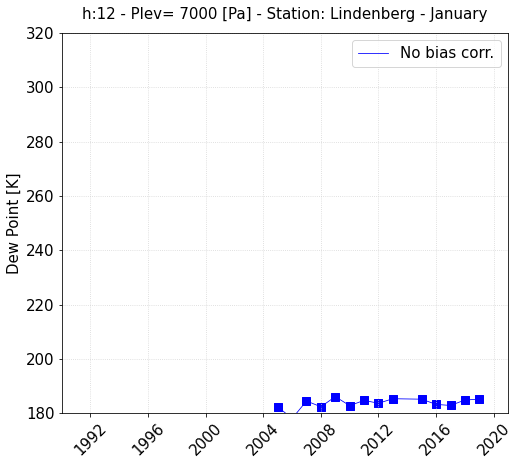

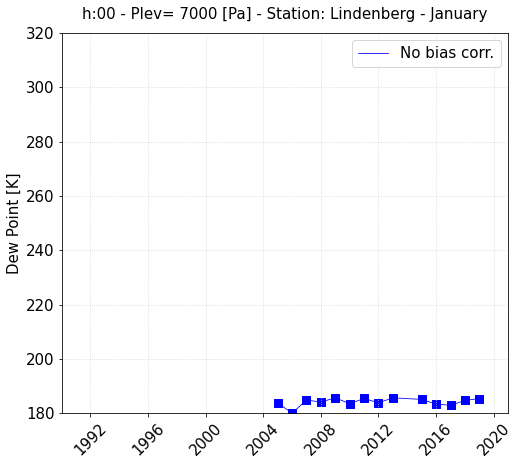

66    66


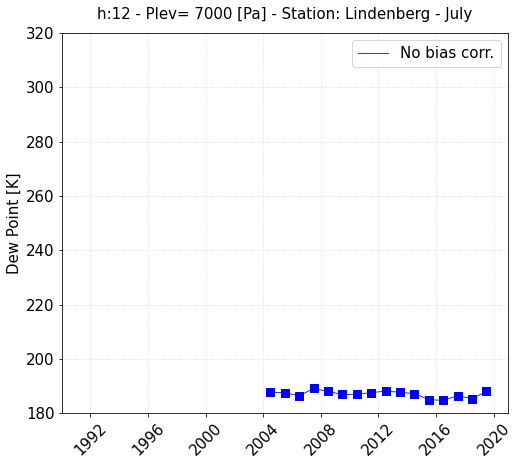

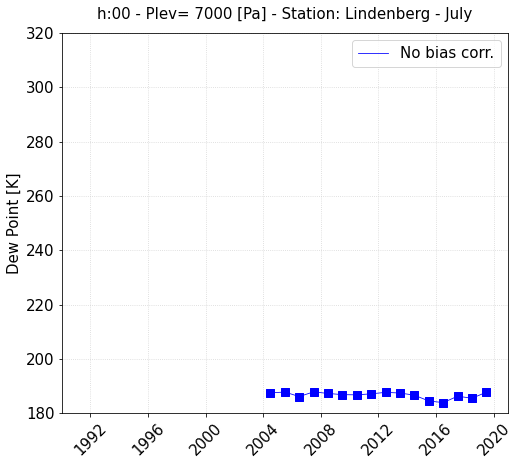

65    65


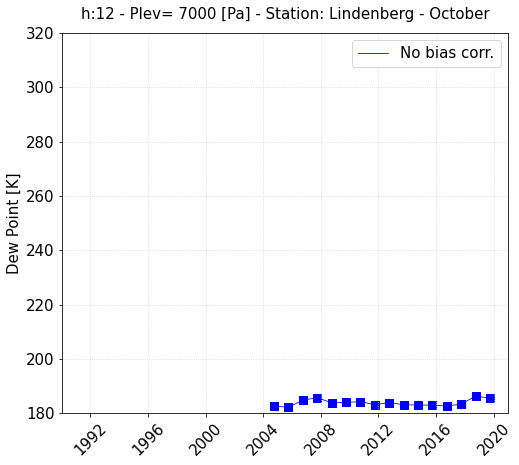

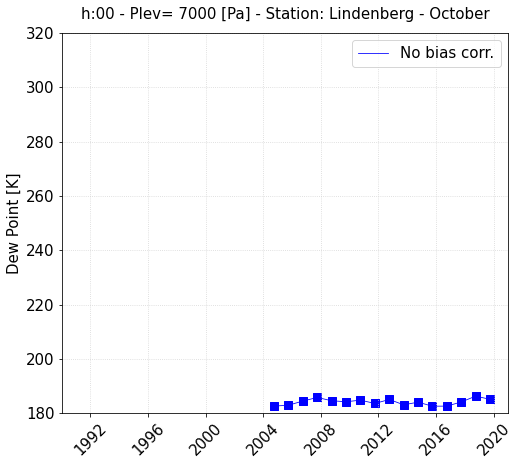

64    64


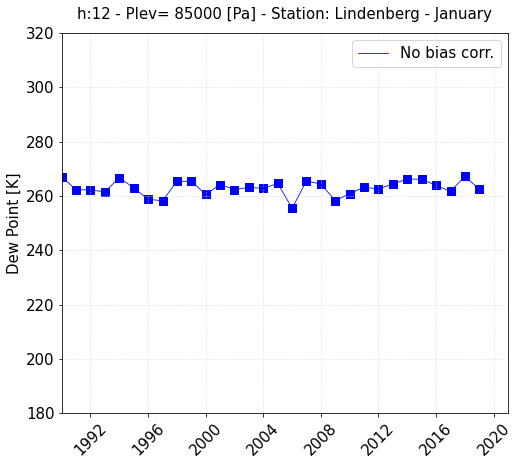

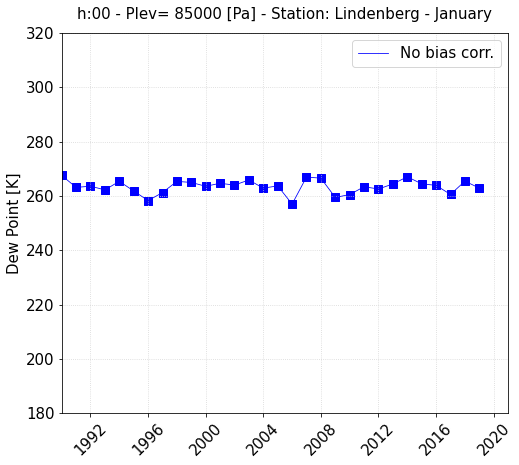

66    66


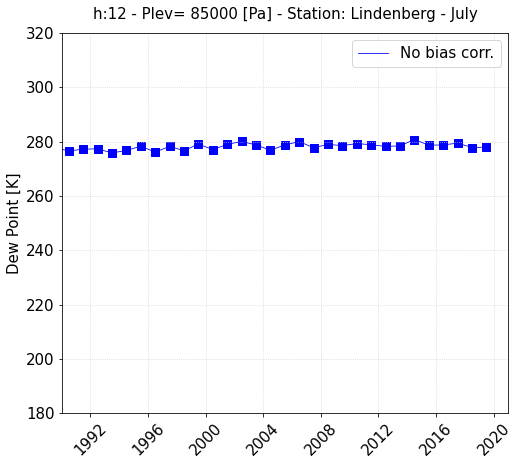

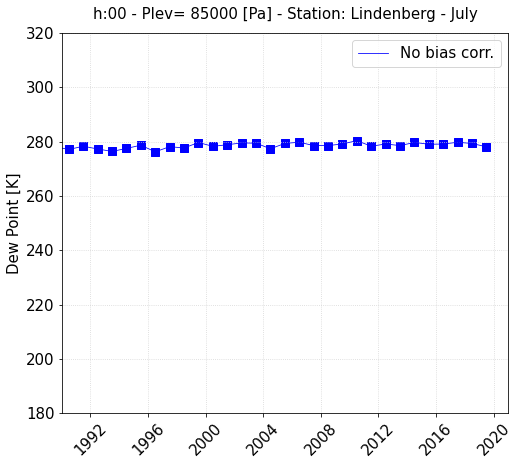

65    65


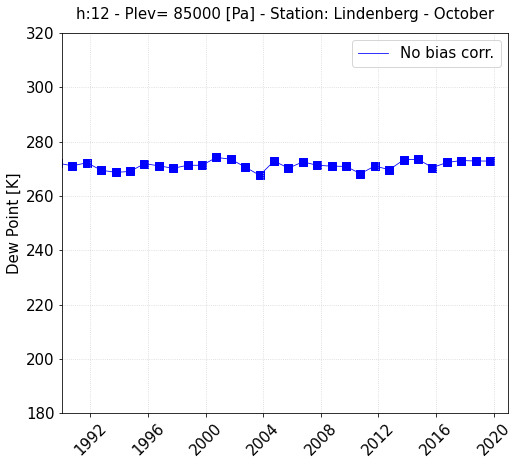

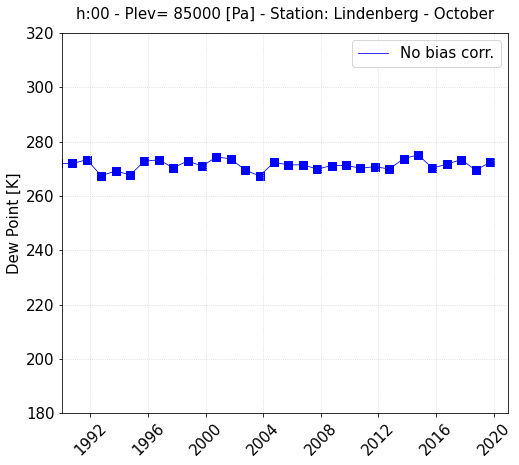

64    64


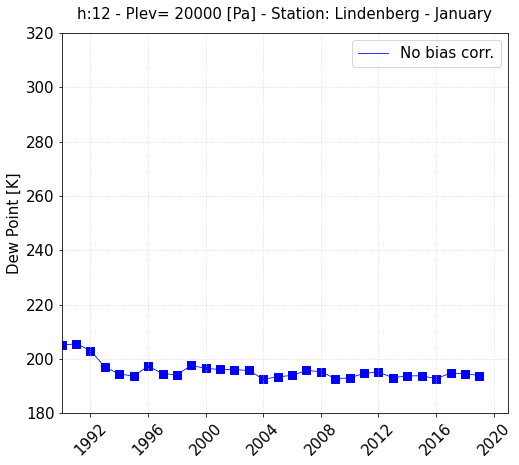

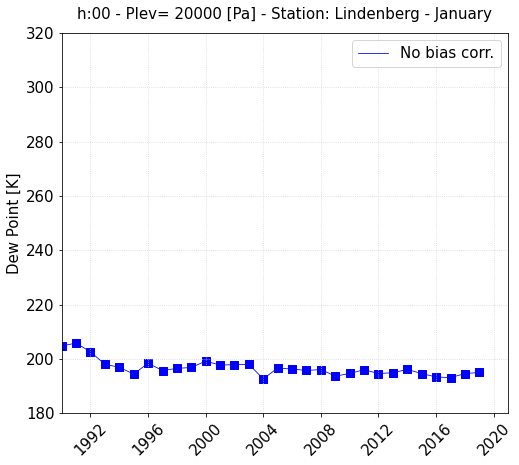

66    66


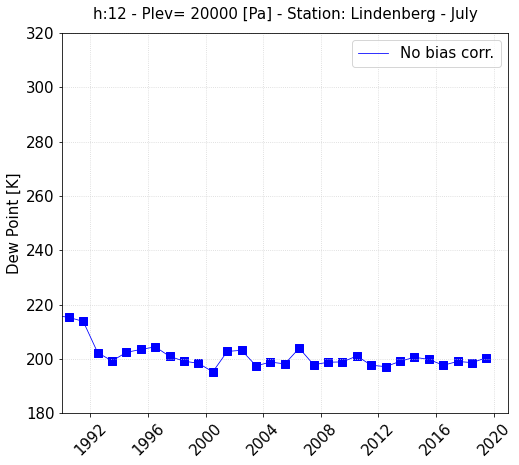

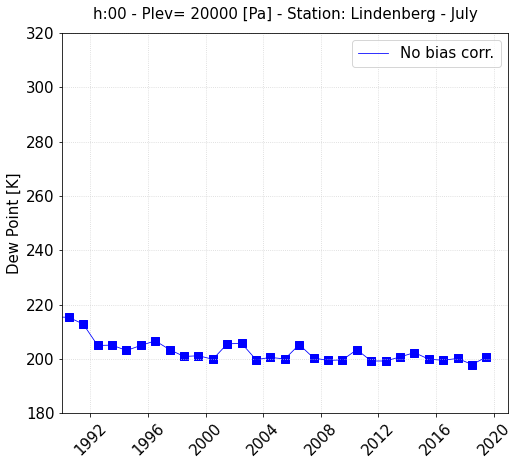

65    65


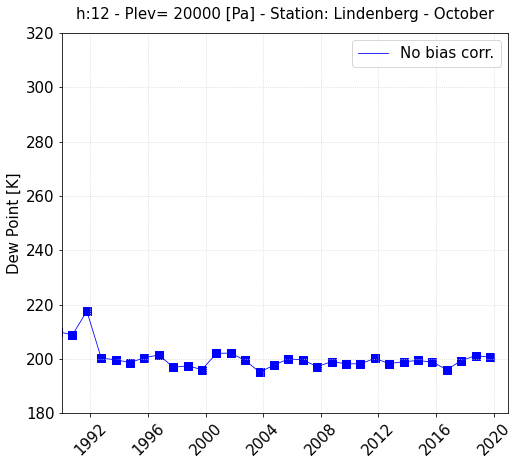

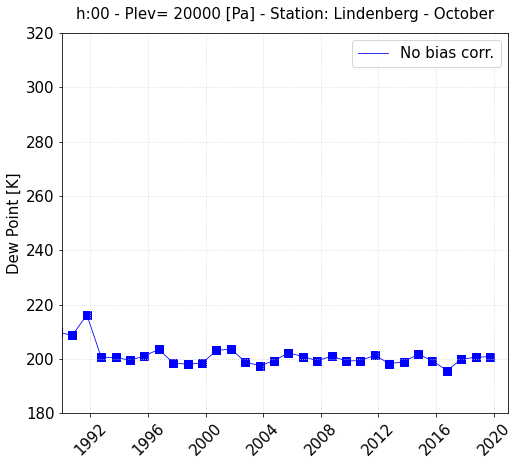

64    64


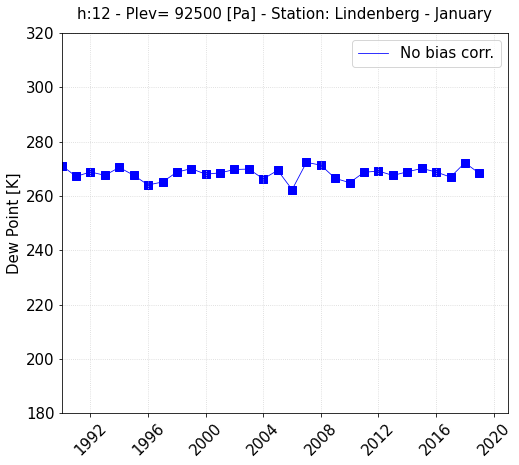

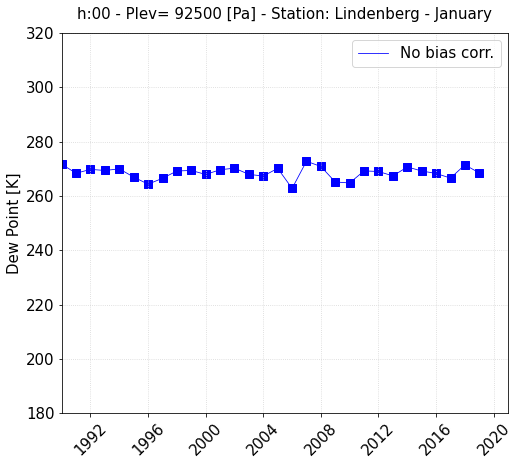

66    66


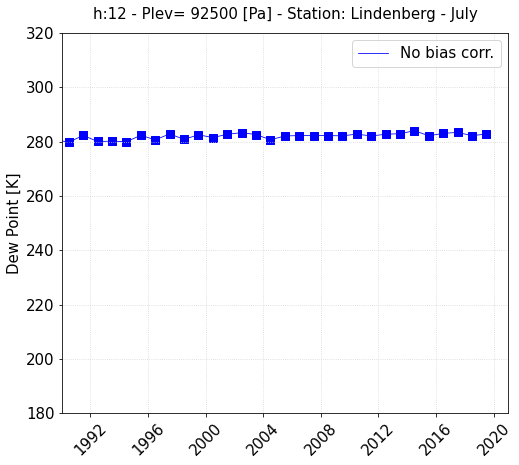

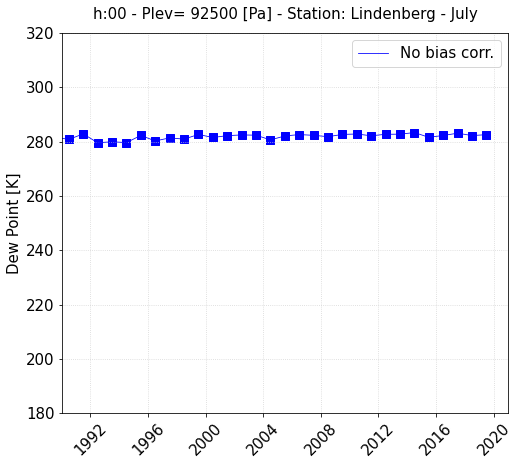

65    65


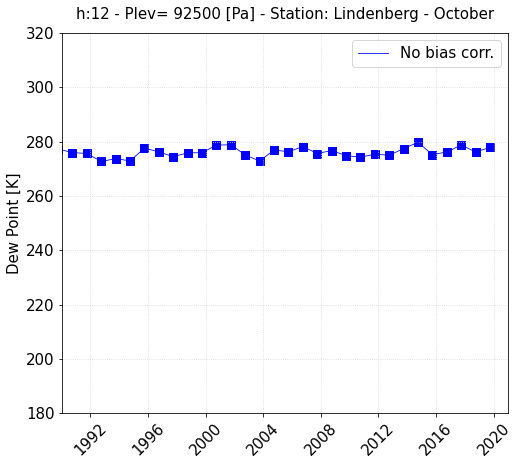

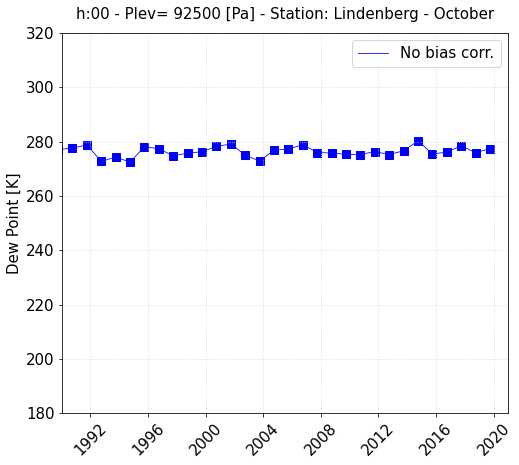

64    64


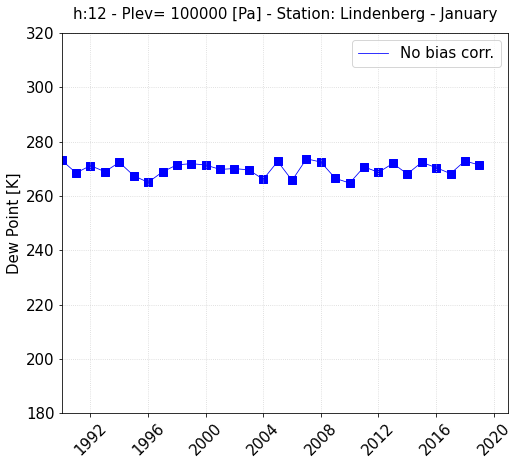

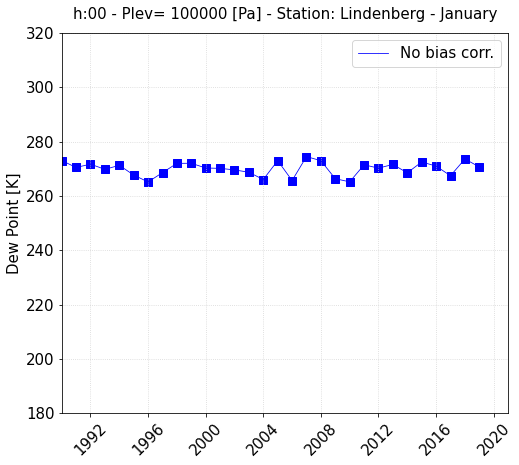

66    66


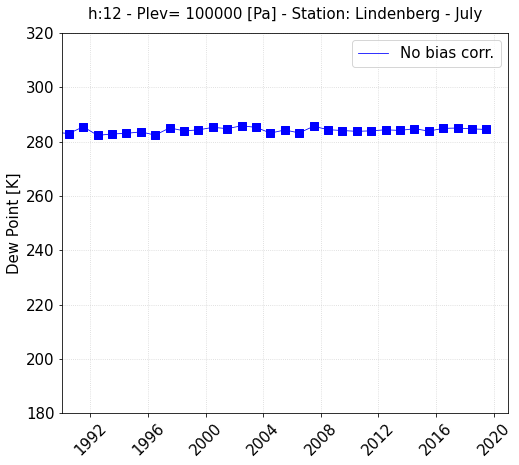

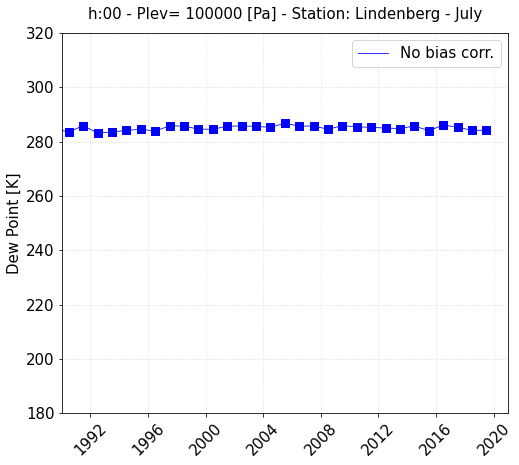

65    65


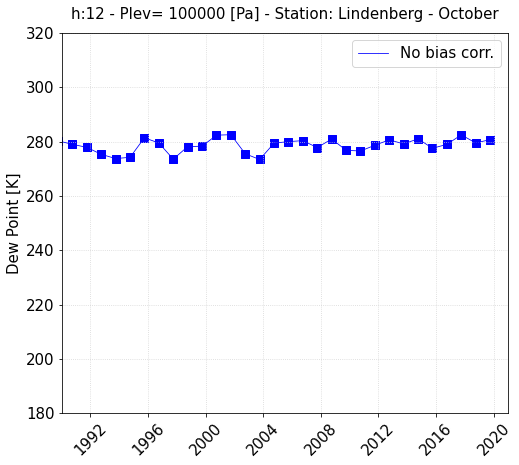

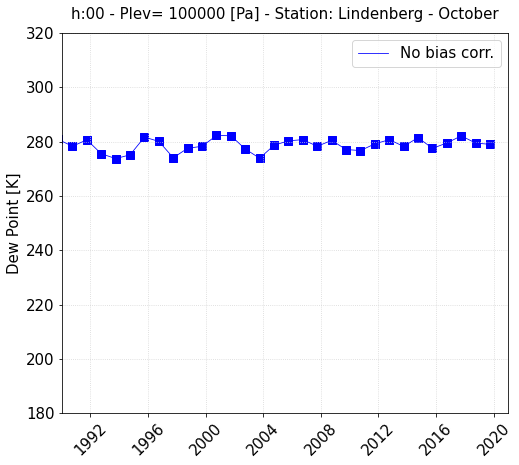

In [21]:
for p in [7000, 85000, 20000, 92500, 100000 ]:
    for m in [1, 7, 10 ]:
        pp = plot_climate_change(average_df = average, min_year = 1900, max_year = 2020 , 
                                 pressure = p  , month = m,  station = station, text = 'zoom', variable = variable )